# -----------------------------
# 1. Data Simulation
# -----------------------------
# We create a synthetic dataset of TD customers, assign them randomly to control (A) or treatment (B),
# and simulate whether they convert to paperless billing. We also simulate guardrail metrics.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(42)
N = 20000


customers = pd.DataFrame({
"customer_id": np.arange(N),
"segment": rng.choice(["youth","mass","affluent"], size=N, p=[0.2,0.6,0.2]),
"age": rng.integers(18,80,size=N),
"province": rng.choice(["ON","QC","BC","AB","MB","NS","NB","SK","NL","PE"], size=N,
p=[0.38,0.23,0.14,0.12,0.03,0.03,0.03,0.02,0.01,0.01]),
"preferred_channel": rng.choice(["email","push","sms"], size=N, p=[0.65,0.3,0.05])
})

# Random assignment to variants

In [3]:
customers["variant"] = rng.choice(["A","B"], size=N)

# Baseline conversion rate and adjustments by segment and channel

In [4]:
base = 0.08
seg_adj = customers["segment"].map({"youth":0.00,"mass":0.00,"affluent":0.02}).values
ch_adj = customers["preferred_channel"].map({"email":0.00,"push":0.01,"sms":-0.02}).values

# Treatment effect: adds uplift if in group B, with stronger effect for youth and push channel

In [5]:
te = np.where(customers["variant"].eq("B"), 0.025, 0.0)
te += np.where((customers["variant"].eq("B")) & (customers["segment"].eq("youth")), 0.01, 0.0)
te += np.where((customers["variant"].eq("B")) & (customers["preferred_channel"].eq("push")), 0.005, 0.0)

# Generate conversion outcomes based on probabilities

In [6]:
p_conv = np.clip(base + seg_adj + ch_adj + te, 0, 1)
customers["converted"] = rng.binomial(1, p_conv)

# Simulate guardrail metrics (unsubscribe/complaints)

In [14]:
customers["unsubscribe"] = rng.binomial(1, np.where(customers["variant"].eq("B"), 0.004, 0.004))
customers["complaint"] = rng.binomial(1, np.where(customers["variant"].eq("B"), 0.002, 0.002))

customers.head()

,customer_id,segment,age,province,preferred_channel,variant,converted,unsubscribe,complaint
0,0,mass,73,ON,push,A,0,0,0
1,1,mass,63,QC,email,A,0,0,0
2,2,affluent,30,NL,email,B,0,0,0
3,3,mass,79,ON,email,A,0,0,0
4,4,youth,79,ON,email,A,0,0,0


# -----------------------------
# 2. Randomization Check (SRM)
# -----------------------------
# Check that random assignment produced balanced groups. If the test is significant, we may have SRM.

In [9]:
obs = customers["variant"].value_counts().values
chi2, p_val = st.chisquare(obs, f_exp=[N/2, N/2])
print("SRM Test (Chi-square)", {"chi2":chi2, "p_value":p_val})

SRM Test (Chi-square) {'chi2': np.float64(0.3362), 'p_value': np.float64(0.5620309098445604)}


# Compare balance by key covariates (segment, channel)

In [11]:
print("Segment balance:")
print(pd.crosstab(customers["segment"], customers["variant"], normalize="index"))

print("Channel balance:")
print(pd.crosstab(customers["preferred_channel"], customers["variant"], normalize="index"))

Segment balance:
variant          A         B
segment                     
affluent  0.501767  0.498233
mass      0.500499  0.499501
youth     0.486534  0.513466
Channel balance:
variant                   A         B
preferred_channel                    
email              0.496768  0.503232
push               0.498261  0.501739
sms                0.511868  0.488132


# -----------------------------
# 3. Primary Analysis (Proportions test)
# -----------------------------
# We run a two-sample proportion z-test to see if conversion rate is higher in treatment (B).

In [15]:
tab = pd.crosstab(customers["variant"], customers["converted"])
conv_A = tab.loc["A",1] / tab.loc["A"].sum()
conv_B = tab.loc["B",1] / tab.loc["B"].sum()

res = sm.stats.proportions_ztest([tab.loc["B",1], tab.loc["A",1]],
[tab.loc["B"].sum(), tab.loc["A"].sum()],
alternative="larger")
uplift = conv_B - conv_A

print("Conversion Rates:", {"A":conv_A, "B":conv_B, "uplift_pp":uplift*100, "p_value":res[1]})

Conversion Rates: {'A': np.float64(0.08705693342705091), 'B': np.float64(0.11492879195299273), 'uplift_pp': np.float64(2.787185852594182), 'p_value': np.float64(3.096571234256285e-11)}


# -----------------------------
# 4. Logistic Regression (adjust for covariates)
# -----------------------------
# We fit a logistic regression to estimate the treatment effect while adjusting for covariates.

In [16]:
df = customers.copy()
df["treat"] = (df["variant"]=="B").astype(int)

model = smf.logit("converted ~ treat + C(segment) + C(preferred_channel) + age", data=df).fit(disp=False)
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19993
Method:                           MLE   Df Model:                            6
Date:                Fri, 19 Sep 2025   Pseudo R-squ.:                0.006452
Time:                        01:19:46   Log-Likelihood:                -6505.4
converged:                       True   LL-Null:                       -6547.7
Covariance Type:            nonrobust   LLR p-value:                 4.206e-16
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.1579      0.087    -24.915      0.000      -2.328      -1.988
C(segment)[T.mass]              -0.2956      0.058     -5.136      0.000     

# Odds ratio for treatment effect

In [17]:
treat_or = np.exp(model.params["treat"])
print("Treatment Odds Ratio:", treat_or)

Treatment Odds Ratio: 1.3630907865641977


# -----------------------------
# 5. Heterogeneous Effects
# -----------------------------
# Examine treatment effects by segment and by communication channel.

In [18]:
seg_results = df.groupby(["segment","variant"])['converted'].mean().unstack()
print("Conversion by Segment:\n", seg_results)

channel_results = df.groupby(["preferred_channel","variant"])['converted'].mean().unstack()
print("Conversion by Channel:\n", channel_results)

Conversion by Segment:
 variant          A         B
segment                     
affluent  0.108652  0.138298
mass      0.083389  0.106358
youth     0.076371  0.117533
Conversion by Channel:
 variant                   A         B
preferred_channel                    
email              0.086445  0.110414
push               0.093085  0.128425
sms                0.058468  0.090909


# -----------------------------
# 6. Guardrail Metrics
# -----------------------------
# Ensure that unsubscribe and complaint rates are not significantly worse in treatment.

In [20]:
for m in ["unsubscribe","complaint"]:
    tab = pd.crosstab(df["variant"], df[m])
    p = sm.stats.proportions_ztest([tab.loc["B",1], tab.loc["A",1]],
                                   [tab.loc["B"].sum(), tab.loc["A"].sum()],
                                   alternative="larger")[1]
print(m, {"rate_A": tab.loc["A",1]/tab.loc["A"].sum(),
          "rate_B": tab.loc["B",1]/tab.loc["B"].sum(),
          "p_value": p})

complaint {'rate_A': np.float64(0.0029119389496937444), 'rate_B': np.float64(0.002191016830992929), 'p_value': np.float64(0.8439376853733327)}


# -----------------------------
# 7. Visualization
# -----------------------------
# Simple bar chart comparing conversion rates between A and B.

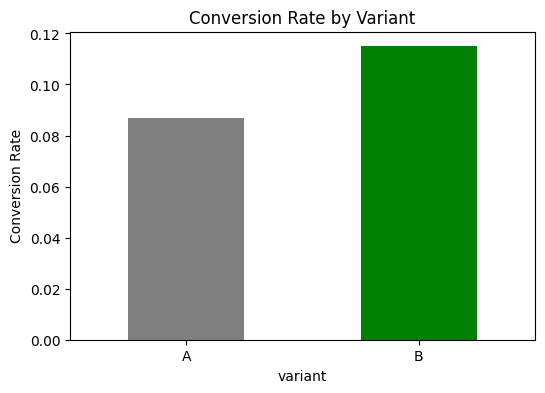

In [21]:
fig, ax = plt.subplots(figsize=(6,4))
bar = df.groupby("variant")["converted"].mean().plot(kind="bar", ax=ax, color=["gray","green"])
plt.title("Conversion Rate by Variant")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=0)
plt.show()

# -----------------------------
# 8. Conclusion
# -----------------------------
# Interpret results and print a conclusion statement.

In [22]:
print("\nConclusion:")
if res[1] < 0.05:
    print(f"The sustainability nudge increased paperless adoption by {uplift*100:.2f} pp with statistical significance (p={res[1]:.3f}).")
else:
    print("No significant uplift detected. Continue monitoring or run a larger sample.")


Conclusion:
The sustainability nudge increased paperless adoption by 2.79 pp with statistical significance (p=0.000).
